In [3]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
# import model_explain.shap as meshap
import tensorflow as tf
from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

## Load Data 

In [4]:
raw_data = pd.read_csv(os.path.join(root_path, "sentiment140_twitter.csv"), names=['target', 'id', 'date', 'flag', 'user', 'text'], header=None)
data = raw_data[raw_data.text.isnull()==False].drop_duplicates().reset_index(drop=True)
data['hashtag'] = data['text'].apply(lambda x: textClean.get_hashtag(x))
data['atuser'] = data['text'].apply(lambda x: re.findall(r"@(\w+)", x))
data['clean_tweet'] = data['text'].apply(lambda x: textClean.remove_string_startwith(x, '@'))
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: textClean.remove_string_startwith(x, '#'))
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: textClean.remove_string_startwith(x, 'http'))
data['label'] = np.where(data['target']==0, 0, 1)

In [3]:
data.head(3)

target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   

              user                                               text hashtag  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...      []   
1    scotthamilton  is upset that he can't update his Facebook by ...      []   
2         mattycus  @Kenichan I dived many times for the ball. Man...      []   

         atuser                                        clean_tweet  label  
0  [switchfoot]    - Awww, that's a bummer.  You shoulda got Da...      0  
1            []  is upset that he can't update his Facebook by ...      0  
2    [Kenichan]   I dived many times for the ball. Managed to s...      0

In [4]:
i = 175
print(data.text[i])
print("-----------")
# print(data.clean_tweet[i])
print("-----------")
print(data.clean_tweet[i])

@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail
-----------
-----------
 I'm so sorry you're having to go through this. Again.  


## Explore Data
We run Explore Data in sample dataset.

In [13]:
import random
sample_size = 100000

sample_data = pd.concat([data.loc[data['hashtag'].str.len() > 0], data.loc[data['hashtag'].str.len() == 0].sample((sample_size - len(data.loc[data['hashtag'].str.len() > 0])), random_state = 3)]).reset_index(drop = True)
pos_tweet = list(x.split() for x in sample_data[sample_data['label']==1]['clean_tweet'])
neg_tweet = list(x.split() for x in sample_data[sample_data['label']==0]['clean_tweet'])
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tweet, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tweet, top_n_tokens = 30)
print('top 30 negative review tfidf', negtop10tfidf)
print('top 30 positive review tfidf', postop10tfidf)

top 30 negative review tfidf ['holidays', 'gue', 'heartbroken', 'heartbreaking', 'headache...', 'headache!', 'headache', 'having', 'has', 'grr', 'confused', 'goodbye', 'geez', 'fun', 'froze', 'from', 'friends', 'freezing', 'CANT', 'here', 'homework', 'But', 'inside', 'including', 'in', 'images', 'im', 'ich', "i'm", 'i']
top 30 positive review tfidf ['!', 'Yay', 'Yes', 'Yep!', 'Yeah', 'Yea,', 'Yay!!', 'Yay!', 'YOUR', 'Will', 'YAY!!', 'YAY!', 'YAY', 'XD', 'Woo', 'Wonderful', 'Yes!', 'You', 'Yum.', 'Yummy', 'Yup', 'Zac', '[', 'a', 'about', 'actually', 'again', 'again.', 'again?', 'agree']


In [14]:
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tweet, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tweet, topn = 10)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('the', 17631), ('to', 15956), ('I', 12105), ('a', 11983), ('for', 9493), ('you', 9031), ('and', 8689), ('is', 6774), ('my', 6656), ('in', 6253)]
[('to', 18431), ('I', 17882), ('the', 15657), ('a', 10622), ('my', 9509), ('and', 8212), ('i', 8005), ('is', 7371), ('in', 6851), ('for', 6392)]


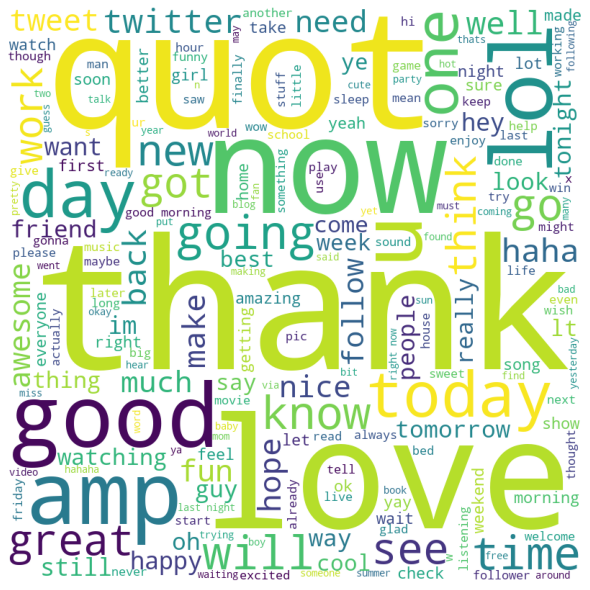

In [15]:
DataExploration.generate_word_cloud(pos_tweet)

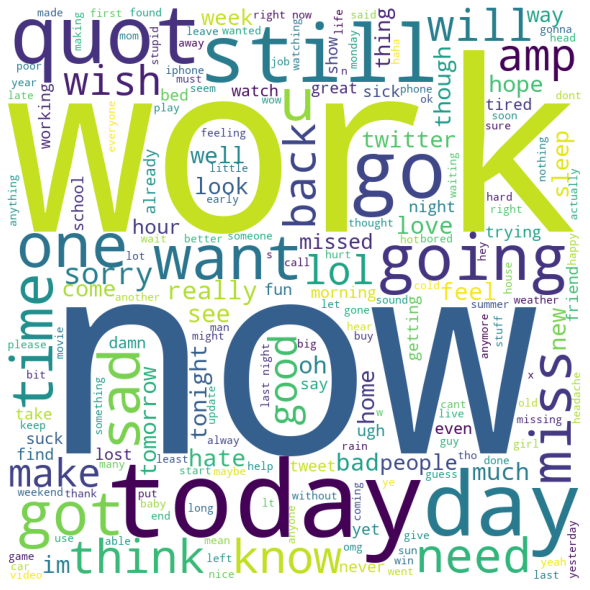

In [16]:
DataExploration.generate_word_cloud(neg_tweet)

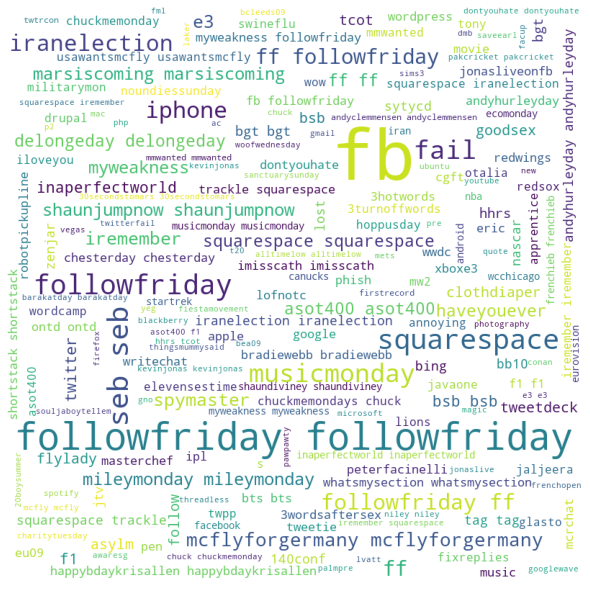

In [18]:
hashtag_list = list(sample_data.hashtag)
DataExploration.generate_word_cloud(hashtag_list)

We didn't remove stop words, so the LDA does not work well, to do topic modelling, we need to remove stop words. But for sentiment analysis, it is better to keep all words.
However, even for sentiment analysis, we need to set minimal words length, there we need to set it as 2.

In [164]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(pos_tweet, num_topics = no_topics)
lda.lda_topics(lda_allbow)

Topics var1  var2    var3 var4    var5 var6   var7  var8  var9  var10
0       1  you  your     the  for       I   of      a   and  have  Thank
1       2    i    to      my  and       a  the   just    in    is     it
2       3    a     -      my   in      of  the    and  like    is   from
3       4    I   the       a   of       i   it   that   was    to    for
4       5   to     I     the  and       a   in  going  some   off     go
5       6   to   and     you  the      on    I      i    me     u     my
6       7  the    is    with    I     and   in   this    on    my      a
7       8  you     a      to  the     are    i     on    of    in     is
8       9  for   the  thanks   my  Thanks    a     to   all   and     is
9      10   to   and      my  for     the    a    I'm     I    in     me

## Prepare training/testing/validation dataset

In [2]:
X = [x for x in data.clean_tweet]
y = np.array(data.label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 11)

NameError: name 'data' is not defined

## Word Embedding & RNN

### Glove Word Embedding

In [6]:
# load the whole embedding into memory
embeddings_index = dict()
embedding_dim = 100 
# download glove word embedding first and then load it with the following code
f = open('C:/ProgramData/Anaconda3/append_file/glove/glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close
print('loaded %s word vectors.' % len(embeddings_index))

loaded 400000 word vectors.


In [7]:
max_length = int(np.percentile(data.clean_tweet.apply(lambda x: len(x.split())), 95))
# we also tried max length, but it cause overfitting

t = Tokenizer()
t.fit_on_texts(X_train)
# print("words with freq:", t.word_docs)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train)
print('Encoding:\n', encoded_docs[0])
print('\nText:\n', list(X_train)[0])
print('\nWord Indices:\n', [(t.index_word[i], i) for i in encoded_docs[0]])
print('vocab size:', vocab_size)
train_padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')


Encoding:
 [7708, 30, 1176, 23, 14140, 741, 6, 4, 133, 8029, 59, 23, 868, 10969, 350, 24, 17, 7708, 18, 9, 25, 110]

Text:
 Eventful day- fire at sears park and a nice splash about at david lloyd. Okay not THAT eventful but it was fun 

Word Indices:
 [('eventful', 7708), ('day', 30), ('fire', 1176), ('at', 23), ('sears', 14140), ('park', 741), ('and', 6), ('a', 4), ('nice', 133), ('splash', 8029), ('about', 59), ('at', 23), ('david', 868), ('lloyd', 10969), ('okay', 350), ('not', 24), ('that', 17), ('eventful', 7708), ('but', 18), ('it', 9), ('was', 25), ('fun', 110)]
vocab size: 247404


In [8]:
# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, idx_word in t.word_index.items():
    word_vector = embeddings_index.get(word)
    if word_vector is not None:
        embedding_matrix[idx_word] = word_vector
print('word:', t.index_word[1])
print('Embedding:\n', embedding_matrix[1])
print('length of embedding matrix is:', len(embedding_matrix))
print('vocabulary size is %s.' % vocab_size)

word: i
Embedding:
 [-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1.43809998  0.99125999
  0.13976     1.34739995 -1.1753      0.0039503   1.02980006  0.064637
  0.90886998  0.82871997 -0.47003001 -0.10575     0.5916     -0.42210001
  0.57331002 -0.54114002  0.10768     0.39783999 -0.048744    0.064596
 -0.61436999 -0.28600001  0.50669998 -0.49757999 -0.81

In [93]:
from scipy.spatial import distance
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key = lambda word: distance.euclidean(embeddings_index[word], embedding))
find_closest_embeddings((embedding_matrix[t.word_index['welcome']]))

['welcome',
 'welcoming',
 'welcomed',
 'wish',
 'occasion',
 'inviting',
 'hoped',
 'eager',
 'hoping',
 'opportunity',
 'hope',
 'surprise',
 'invitation',
 'embrace',
 'greet',
 'happy',
 'greeted',
 'promise',
 'come',
 'calling',
 'thank',
 'wishes',
 'praise',
 'invite',
 'delighted',
 'assured',
 'arrival',
 'ready',
 'encouragement',
 'wishing',
 'wished',
 'expect',
 'gesture',
 'call',
 'sort',
 'welcomes',
 'coming',
 'offered',
 'give',
 'pleased',
 '404-222-8268',
 'promised',
 'encouraged',
 'return',
 'urge',
 'wanting',
 'invited',
 'sign',
 'promises',
 'cheer',
 'indeed',
 'thanks',
 'leave',
 'grateful',
 'reminded',
 'enthusiastic',
 'bring',
 'urging',
 'noting',
 'given',
 'supportive',
 'nonetheless',
 'prepared',
 'reception',
 'nod',
 'immediate',
 'moment',
 'celebrate',
 'surely',
 'accept',
 'acceptance',
 'farewell',
 'waiting',
 'delight',
 'hopeful',
 'satisfied',
 'impression',
 'see',
 'certainly',
 'yet',
 'regard',
 'triumphant',
 'promising',
 'genui

In [9]:
encoded_val_doc = t.texts_to_sequences(X_val)
padded_val_doc = pad_sequences(encoded_val_doc, maxlen = max_length, padding = 'post')
encoded_test_doc = t.texts_to_sequences(X_test)
padded_test_doc = pad_sequences(encoded_test_doc, maxlen = max_length, padding = 'post')

### RNN

In [16]:
model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False),
        Flatten(),
        Dense(embedding_dim, activation="relu", name="layer1"),
        Dense(1, activation = 'sigmoid', name="layer2")
        
    ]
)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           24740400  
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               250100    
_________________________________________________________________
layer2 (Dense)               (None, 1)                 101       
Total params: 24,990,601
Trainable params: 250,201
Non-trainable params: 24,740,400
_________________________________________________________________
None


In [65]:
history = model.fit(train_padded_docs, y_train, epochs = 10, verbose = 1, batch_size = 32, validation_data = (padded_val_doc, y_val))

Epoch 1/10
35000/35000 [==============================] - 56s 2ms/step - loss: 0.5642 - acc: 0.7016 - val_loss: 0.5272 - val_acc: 0.7331
Epoch 2/10
35000/35000 [==============================] - 55s 2ms/step - loss: 0.5139 - acc: 0.7417 - val_loss: 0.5155 - val_acc: 0.7424
Epoch 3/10
35000/35000 [==============================] - 55s 2ms/step - loss: 0.4917 - acc: 0.7574 - val_loss: 0.5155 - val_acc: 0.7440
Epoch 4/10
35000/35000 [==============================] - 55s 2ms/step - loss: 0.4757 - acc: 0.7670 - val_loss: 0.5202 - val_acc: 0.7430
Epoch 5/10
35000/35000 [==============================] - 56s 2ms/step - loss: 0.4622 - acc: 0.7756 - val_loss: 0.5195 - val_acc: 0.7430
Epoch 6/10
35000/35000 [==============================] - 56s 2ms/step - loss: 0.4495 - acc: 0.7845 - val_loss: 0.5246 - val_acc: 0.7443
Epoch 7/10
35000/35000 [==============================] - 56s 2ms/step - loss: 0.4389 - acc: 0.7909 - val_loss: 0.5282 - val_acc: 0.7433
Epoch 8/10
35000/35000 [=================

In [66]:
acc = history.history['acc']
print ("Accuracy history: ",acc)
val_acc = history.history['val_acc']
print("\nValidation history: ",val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy history:  [0.7170875072479248, 0.7419106960296631, 0.7553062438964844, 0.7651187777519226, 0.7734035849571228, 0.7809875011444092, 0.7868321537971497, 0.7921928763389587, 0.7971857190132141, 0.8011205196380615]

Validation history:  [0.7330562472343445, 0.7424250245094299, 0.7440124750137329, 0.7430124878883362, 0.7429562211036682, 0.7443062663078308, 0.7432875037193298, 0.7407249808311462, 0.7401750087738037, 0.7387562394142151]


Tried different pre-processing, with more pre-processing, we loss more information, but with raw data we have http web link and @ or #, which are noise, so in the end, we remove the hashtag, userid start with @ and the http link.

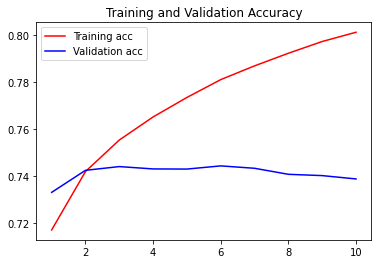

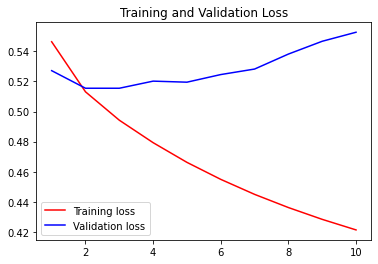

In [67]:
# plot loss rate and accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color = 'r', label = 'Training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'Validation acc')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs, loss, color = 'r', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'b', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


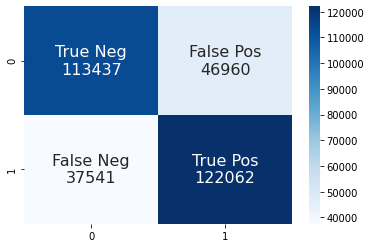

In [68]:
pred_test = model.predict(padded_test_doc)
rounded_pred_test = np.round(pred_test)
cf_matrix = confusion_matrix(y_test, rounded_pred_test)
meplot.cf_matrix_heatmap(cf_matrix)

In [69]:
print(classification_report(y_test,rounded_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73    160397
           1       0.72      0.76      0.74    159603

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



To avoid overfitting, use epochs = 4.

In [17]:
history = model.fit(train_padded_docs, y_train, epochs = 2, verbose = 1, batch_size = 32, validation_data = (padded_val_doc, y_val))

Epoch 1/2
35000/35000 [==============================] - 56s 2ms/step - loss: 0.5635 - acc: 0.7020 - val_loss: 0.5274 - val_acc: 0.7335
Epoch 2/2
35000/35000 [==============================] - 55s 2ms/step - loss: 0.5126 - acc: 0.7425 - val_loss: 0.5165 - val_acc: 0.7409


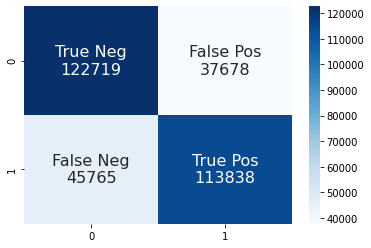

In [19]:
pred_test = model.predict(padded_test_doc)
rounded_pred_test = np.round(pred_test)
cf_matrix = confusion_matrix(y_test, rounded_pred_test)
meplot.cf_matrix_heatmap(cf_matrix)

In [20]:
print(classification_report(y_test,rounded_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75    160397
           1       0.75      0.71      0.73    159603

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



### Model Explainability
Reference: https://github.com/slundberg/shap

#### Lime

In [21]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

def predict_for_lime(text_array):
    encoded =t.texts_to_sequences(text_array)
    text_data = pad_sequences(encoded, maxlen=max_length,padding='post')
    pred=model.predict(text_data)
    return pred

# test the predicition function
print ("Verify if predictions are correct for the function")
print(predict_for_lime([X_test[0],X_test[533]]))
print(y_test[0], y_test[533])
#initilaize Lime for text
explainer = LimeTextExplainer(class_names=["Positive"])

Verify if predictions are correct for the function
[[0.79939485]
 [0.18590674]]
1 0


In [22]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[0]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

In [23]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[533]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

### LSTM 

In [10]:
from tensorflow.keras.layers import LSTM
lstm_m = Sequential(
    [
        Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False, name = 'embedding'),
        LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, name = 'lstm'),
        Dense(1, activation = 'sigmoid', name="layer2")
    ]
)
lstm_m.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(lstm_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           24740400  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
layer2 (Dense)               (None, 1)                 101       
Total params: 24,820,901
Trainable params: 80,501
Non-trainable params: 24,740,400
_________________________________________________________________
None


In [16]:
history = lstm_m.fit(train_padded_docs, y_train, epochs = 10, verbose = 1, batch_size = 32, 
                     validation_data = (padded_val_doc, y_val))


Epoch 1/10
35000/35000 [==============================] - 545s 16ms/step - loss: 0.4384 - acc: 0.7946 - val_loss: 0.4185 - val_acc: 0.8079
Epoch 2/10
35000/35000 [==============================] - 546s 16ms/step - loss: 0.4280 - acc: 0.8012 - val_loss: 0.4114 - val_acc: 0.8106
Epoch 3/10
35000/35000 [==============================] - 546s 16ms/step - loss: 0.4229 - acc: 0.8040 - val_loss: 0.4063 - val_acc: 0.8158
Epoch 4/10
35000/35000 [==============================] - 547s 16ms/step - loss: 0.4199 - acc: 0.8058 - val_loss: 0.4076 - val_acc: 0.8154
Epoch 5/10
35000/35000 [==============================] - 548s 16ms/step - loss: 0.4177 - acc: 0.8071 - val_loss: 0.4047 - val_acc: 0.8163
Epoch 6/10
35000/35000 [==============================] - 547s 16ms/step - loss: 0.4165 - acc: 0.8076 - val_loss: 0.4026 - val_acc: 0.8165
Epoch 7/10
35000/35000 [==============================] - 545s 16ms/step - loss: 0.4150 - acc: 0.8085 - val_loss: 0.4031 - val_acc: 0.8167
Epoch 8/10
35000/35000 [===

Accuracy history:  [0.7945598363876343, 0.8011597990989685, 0.8040330410003662, 0.8058267831802368, 0.8071392774581909, 0.8075740933418274, 0.8084865808486938, 0.8088151812553406, 0.8093821406364441, 0.8100196719169617]

Validation history:  [0.807937502861023, 0.810575008392334, 0.8157687783241272, 0.8153812289237976, 0.8162500262260437, 0.8165374994277954, 0.8167062401771545, 0.8176000118255615, 0.8178374767303467, 0.8164437413215637]


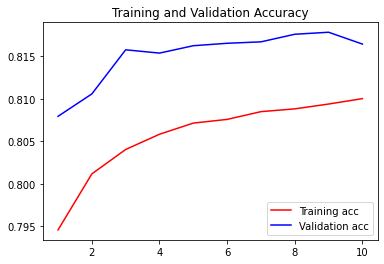

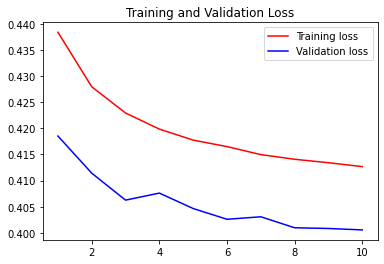

In [18]:
acc = history.history['acc']
print ("Accuracy history: ",acc)
val_acc = history.history['val_acc']
print("\nValidation history: ",val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']
# plot loss rate and accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color = 'r', label = 'Training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'Validation acc')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs, loss, color = 'r', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'b', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


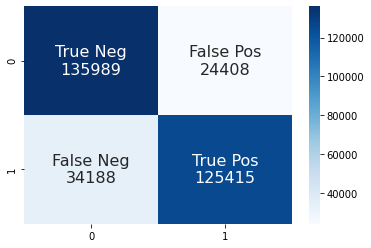

In [19]:
pred_test = lstm_m.predict(padded_test_doc)
rounded_pred_test = np.round(pred_test)
cf_matrix = confusion_matrix(y_test, rounded_pred_test)
meplot.cf_matrix_heatmap(cf_matrix)

In [28]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

def predict_for_lime(text_array):
    encoded =t.texts_to_sequences(text_array)
    text_data = pad_sequences(encoded, maxlen=max_length,padding='post')
    pred=lstm_m.predict(text_data)
    return pred

# test the predicition function
print ("Verify if predictions are correct for the function")
print(predict_for_lime([X_test[2],X_test[511]]))
print(y_test[2], y_test[511])
#initilaize Lime for text
explainer = LimeTextExplainer(class_names=["Positive"])

Verify if predictions are correct for the function
[[0.9939889]
 [0.3029704]]
1 0


In [26]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[2]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

In [29]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[511]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

## DL & Transfer Learning with fastai
some reference:

https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

https://www.kaggle.com/twhelan/covid-19-vaccine-sentiment-analysis-with-fastai


- multivariate classification
- classification with hashtag
- topic modelling with hashtag
- topic modelling 
- word embedding with original text
- classification with pre-trained word embedding (DL)